In [ ]:
import sys

sys.path.append('/explore/nobackup/people/jacaraba/development/satvision-pix4d')

import os
import torch
import logging
import argparse

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

from satvision_pix4d.configs.config import _C, _update_config_from_file
from satvision_pix4d.utils import get_strategy, get_distributed_train_batches
from satvision_pix4d.pipelines import PIPELINES, get_available_pipelines
from satvision_pix4d.datamodules import DATAMODULES, get_available_datamodules
from satvision_pix4d.models.encoders.mae import build_satmae_model
from satvision_pix4d.datasets.abi_temporal_benchmark_dataset import ABITemporalBenchmarkDataset

model_filename = '/explore/nobackup/projects/pix4dcloud/jacaraba/model_development/satmae/' + \
    'satmae_satvision_pix4d_pretrain-dev/satmae_satvision_pix4d_pretrain-dev/epoch-epoch=40.ckpt/checkpoint/mp_rank_00_model_states.pt'

config_filename = '/explore/nobackup/people/jacaraba/development/satvision-pix4d/tests/configs/test_satmae_dev.yaml'

config = _C.clone()
_update_config_from_file(config, config_filename)
print("Loaded configuration file.")

# Add checkpoint (MODEL.PRETRAINED), 
# validation tile dir (DATA.DATA_PATHS),
# and output dir (OUTPUT) to config file
config.defrost()
config.MODEL.PRETRAINED = model_filename
config.OUTPUT = '.'
config.freeze()
print("Updated configuration file.")

# Get the proper pipeline
available_pipelines = get_available_pipelines()
print("Available pipelines:", available_pipelines)

pipeline = PIPELINES[config.PIPELINE]
print(f'Using {pipeline}')

ptlPipeline = pipeline(config)

# Resume from checkpoint
print(f'Attempting to resume from checkpoint {config.MODEL.RESUME}')
model = ptlPipeline.load_checkpoint(config.MODEL.PRETRAINED, config)
print(model)
print('Successfully applied checkpoint')

model.cpu()
model.eval()
print('Successfully moved to GPU')



In [57]:
from satvision_pix4d.datasets.abi_temporal_dataset import ABITemporalDataset

# Use the directory path, not individual files
data_dir = '/explore/nobackup/projects/pix4dcloud/jacaraba/tiles_pix4d/3-tiles/convection/20200101'

# Get all zarr files for reference
all_zarr_files = [f for f in os.listdir(data_dir) if f.endswith('.zarr')]
print(f"Found {len(all_zarr_files)} zarr files in directory")

# Create dataset using the directory (not individual files)
train_ds = ABITemporalDataset(
    data_paths=[data_dir], 
    img_size=512,
    in_chans=16,
    data_var='__xarray_dataarray_variable__'
)

Found 522 zarr files in directory


In [59]:

imgs, ts = train_ds[5]  # imgs: (T, C, H, W), ts: (T, 3)

# Normalize this img
print(imgs.shape)

# 3. Move inputs to GPU
imgs = imgs.unsqueeze(0).cpu()  # (B=1, T, C, H, W)
ts = torch.from_numpy(ts).unsqueeze(0).cpu()  # (B=1, T, 3)

# 4. Run inference
with torch.no_grad():
    loss, pred, mask = model(imgs, ts)

# 5. Post-process output
print("🧪 Inference done!")
print(f"Loss: {loss.item():.4f}")
print(f"Pred shape: {pred.shape}  # should be (B, T*P, D)")
print(f"Mask shape: {mask.shape}  # should be (B, T*P)")

# Optional: Convert prediction to images
B, T, C, H, W = imgs.shape
pred_imgs = model.model.unpatchify(pred, T, H, W)
pred_imgs = torch.clamp(pred_imgs, 0, 1)

print(f"Reconstructed images shape: {pred_imgs.shape}  # (B, T, C, H, W)")

torch.Size([7, 16, 512, 512])
🧪 Inference done!
Loss: 2185.7893
Pred shape: torch.Size([1, 7168, 4096])  # should be (B, T*P, D)
Mask shape: torch.Size([1, 7168])  # should be (B, T*P)
Reconstructed images shape: torch.Size([1, 7, 16, 512, 512])  # (B, T, C, H, W)


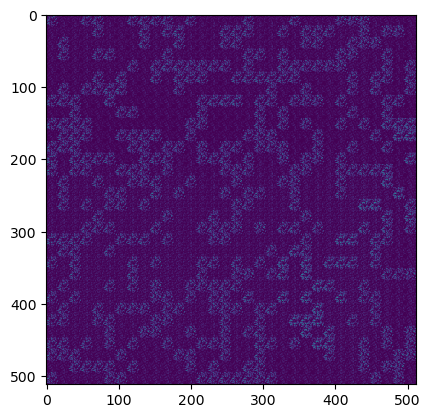

In [77]:
import matplotlib.pyplot as plt
plt.imshow(pred_imgs[0, 0, 10, :, :])

In [71]:
imgs[0, 0, 1, :, :]

tensor([[ 32.6799,  29.5081,  28.8737,  ..., 177.1576,  55.0415,  41.0853],
        [ 30.1425,  30.6182,  28.3979,  ..., 160.5054,  99.2887,  98.0200],
        [ 28.7151,  28.5565,  27.6050,  ..., 104.3637, 104.2051,  99.4473],
        ...,
        [ 22.2128,  22.6886,  32.8385,  ...,  16.8207,  16.3449,  16.3449],
        [ 26.3362,  21.8957,  91.6763,  ...,  16.5035,  15.5520,  16.8207],
        [ 32.3628,  29.9839,  97.7028,  ...,  16.6621,  15.3934,  16.3449]])